In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed(42)
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
data_path = '../data/raw/Salinas_corrected.mat'
gt_path = '../data/raw/Salinas_gt.mat'
data_dict = loadmat(data_path)
gt_dict = loadmat(gt_path)
print("Data keys:", list(data_dict.keys()))
print("GT keys:", list(gt_dict.keys()))
X_salinas = data_dict['salinas_corrected']
y_salinas = gt_dict['salinas_gt']
print(f"Salinas data shape: {X_salinas.shape}")
print(f"Salinas ground truth shape: {y_salinas.shape}")

Data keys: ['__header__', '__version__', '__globals__', 'salinas_corrected']
GT keys: ['__header__', '__version__', '__globals__', 'salinas_gt']
Salinas data shape: (512, 217, 204)
Salinas ground truth shape: (512, 217)


In [3]:
print(f"Data type: {X_salinas.dtype}")
print(f"Data range: [{X_salinas.min()}, {X_salinas.max()}]")
unique_classes, counts = np.unique(y_salinas, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} pixels")
labeled_pixels = y_salinas != 0
print(f"Number of labeled pixels: {np.sum(labeled_pixels)}")

Data type: int16
Data range: [-11, 9207]
Class distribution:
Class 0: 56975 pixels
Class 1: 2009 pixels
Class 2: 3726 pixels
Class 3: 1976 pixels
Class 4: 1394 pixels
Class 5: 2678 pixels
Class 6: 3959 pixels
Class 7: 3579 pixels
Class 8: 11271 pixels
Class 9: 6203 pixels
Class 10: 3278 pixels
Class 11: 1068 pixels
Class 12: 1927 pixels
Class 13: 916 pixels
Class 14: 1070 pixels
Class 15: 7268 pixels
Class 16: 1807 pixels
Number of labeled pixels: 54129


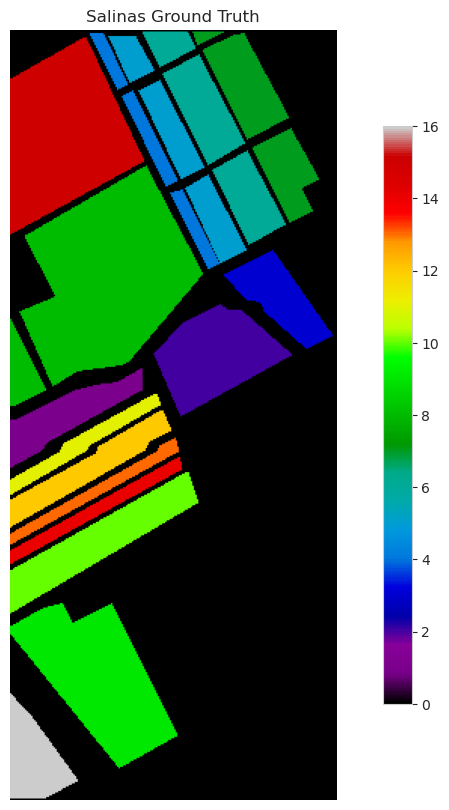

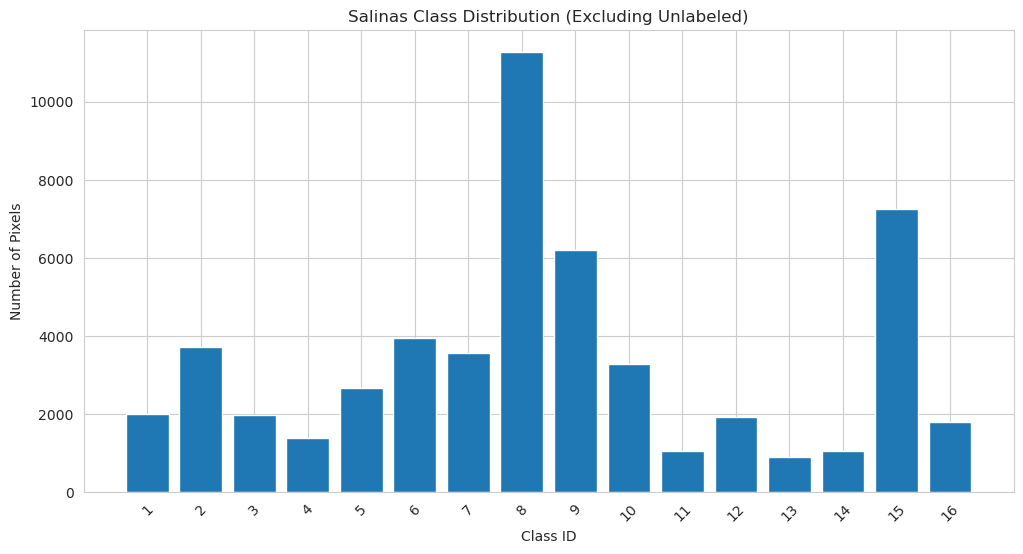

In [4]:
plt.figure(figsize=(12, 10))
plt.imshow(y_salinas, cmap='nipy_spectral')
plt.colorbar(shrink=0.75)
plt.title('Salinas Ground Truth')
plt.axis('off')
plt.show()

class_ids = unique_classes[1:]
class_counts = counts[1:]

plt.figure(figsize=(12, 6))
plt.bar(class_ids.astype(str), class_counts)
plt.title('Salinas Class Distribution (Excluding Unlabeled)')
plt.xlabel('Class ID')
plt.ylabel('Number of Pixels')
plt.xticks(rotation=45)
plt.show()

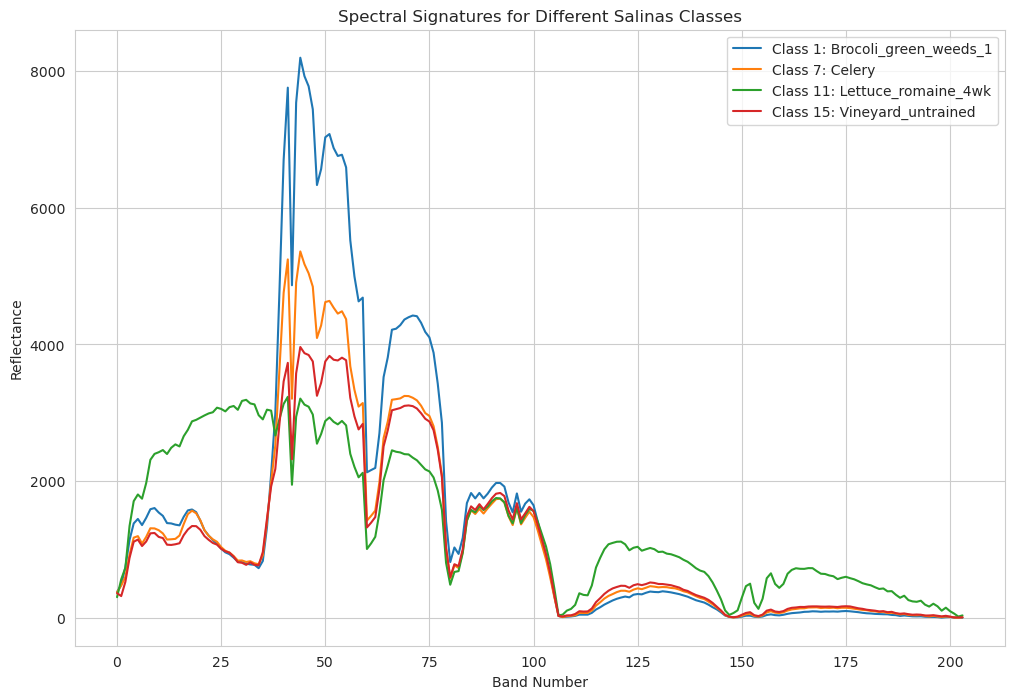

In [5]:
salinas_class_names = [
    'Unknown', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 
    'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery', 
    'Grapes_untrained', 'Soil_vineyard_develop', 'Corn_senesced_green_weeds', 
    'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 
    'Lettuce_romaine_7wk', 'Vineyard_untrained', 'Vineyard_vertical_trellis'
]


plt.figure(figsize=(12, 8))
classes_to_plot = [1, 7, 11, 15]
for class_id in classes_to_plot:
    rows, cols = np.where(y_salinas == class_id)
    if len(rows) > 0:
        idx = np.random.randint(0, len(rows))
        spectrum = X_salinas[rows[idx], cols[idx], :]
        plt.plot(spectrum, label=f'Class {class_id}: {salinas_class_names[class_id]}')
        
plt.title('Spectral Signatures for Different Salinas Classes')
plt.xlabel('Band Number')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

In [6]:
original_shape = X_salinas.shape
X_salinas_flat = X_salinas.reshape(-1, X_salinas.shape[-1])

salinas_scaler = StandardScaler()
X_salinas_scaled_flat = salinas_scaler.fit_transform(X_salinas_flat)

X_salinas_scaled = X_salinas_scaled_flat.reshape(original_shape)

print("Salinas data normalized successfully")
print(f"New data range: [{X_salinas_scaled.min():.2f}, {X_salinas_scaled.max():.2f}]")

Salinas data normalized successfully
New data range: [-6.27, 222.76]


In [7]:
X_salinas_flat_for_pca = X_salinas_scaled.reshape(-1, X_salinas.shape[-1])
salinas_pca = PCA(n_components=30)
X_salinas_pca_flat = salinas_pca.fit_transform(X_salinas_flat_for_pca)
X_salinas_pca = X_salinas_pca_flat.reshape(original_shape[0], original_shape[1], -1)
print(f"Explained variance ratio: {np.sum(salinas_pca.explained_variance_ratio_):.3f}")
print(f"Data after PCA shape: {X_salinas_pca.shape}")

Explained variance ratio: 1.000
Data after PCA shape: (512, 217, 30)


In [8]:
def extract_patches(X, y, patch_size=25):

    half = patch_size // 2
    patches = []
    labels = []

    X_padded = np.pad(X, ((half, half), (half, half), (0, 0)), mode='reflect')
    y_padded = np.pad(y, ((half, half), (half, half)), mode='reflect')

    rows, cols = np.where(y != 0)
    
    for row, col in zip(rows, cols):
        row_adj = row + half
        col_adj = col + half
        
        patch = X_padded[row_adj-half:row_adj+half+1, col_adj-half:col_adj+half+1, :]
        patches.append(patch)
        labels.append(y[row, col])
    
    return np.array(patches), np.array(labels)

X_salinas_patches, y_salinas_patches = extract_patches(X_salinas_pca, y_salinas, patch_size=25)

print(f"Extracted {len(X_salinas_patches)} patches")
print(f"Patch shape: {X_salinas_patches.shape}")
print(f"Labels shape: {y_salinas_patches.shape}")

Extracted 54129 patches
Patch shape: (54129, 25, 25, 30)
Labels shape: (54129,)


In [9]:
import os
os.makedirs('../data/processed/salinas', exist_ok=True)

np.save('../data/processed/salinas/X_salinas_patches.npy', X_salinas_patches)
np.save('../data/processed/salinas/y_salinas_patches.npy', y_salinas_patches)

import joblib
joblib.dump(salinas_scaler, '../data/processed/salinas/salinas_scaler.pkl')
joblib.dump(salinas_pca, '../data/processed/salinas/salinas_pca.pkl')

print("Salinas processed data saved successfully")

Salinas processed data saved successfully


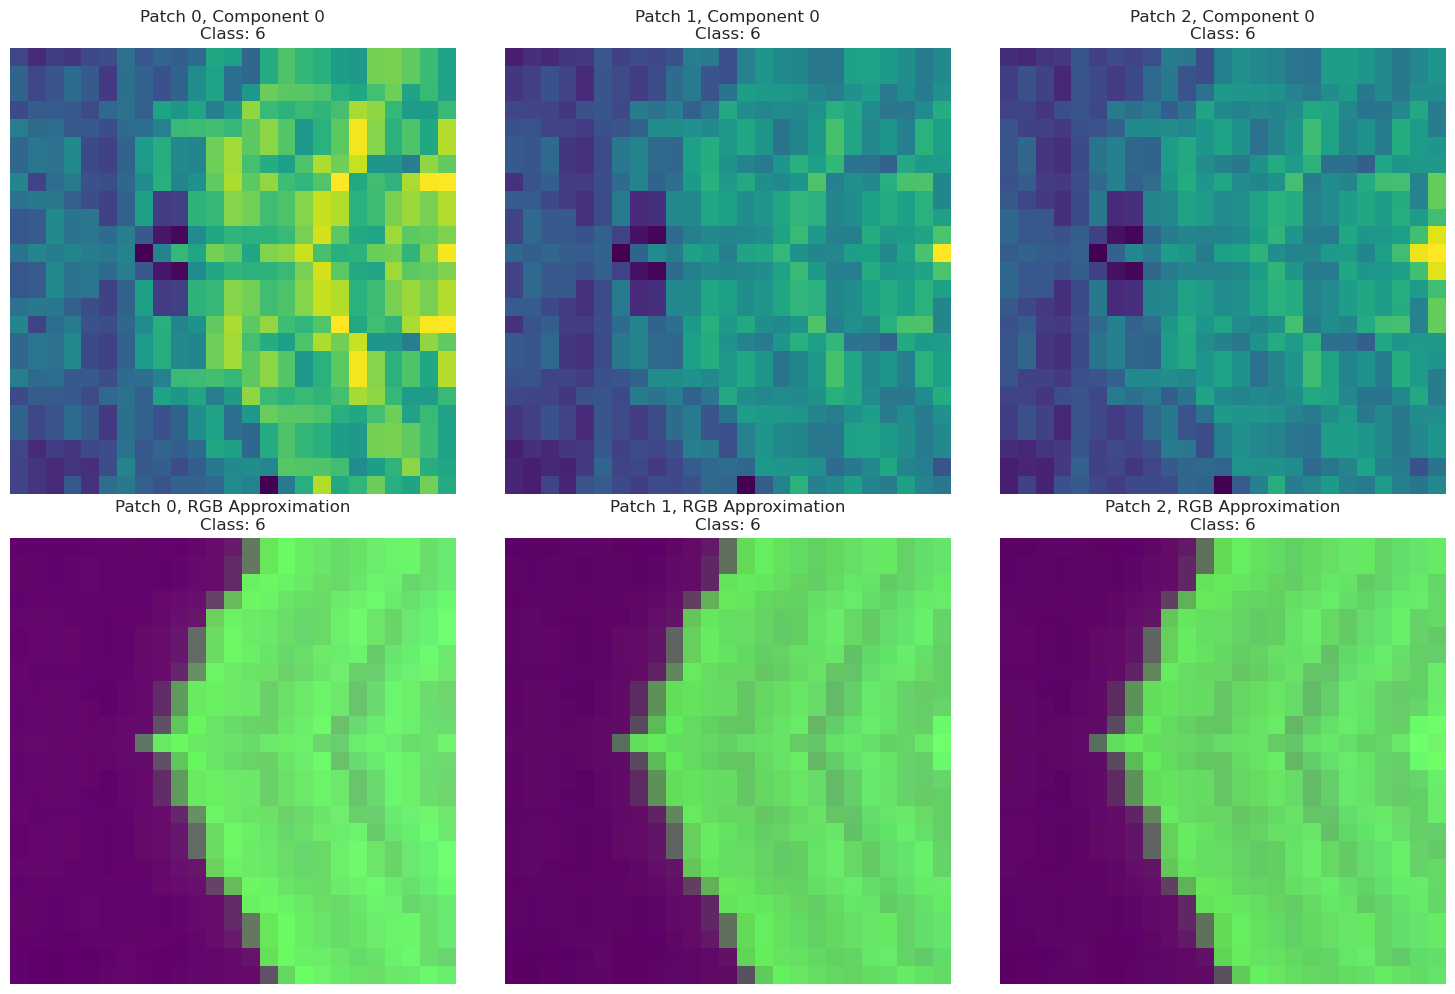

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    axes[0, i].imshow(X_salinas_patches[i, :, :, 0], cmap='viridis')
    axes[0, i].set_title(f'Patch {i}, Component 0\nClass: {y_salinas_patches[i]}')
    axes[0, i].axis('off')
    
    rgb_patch = X_salinas_patches[i, :, :, :3]

    rgb_patch = (rgb_patch - rgb_patch.min()) / (rgb_patch.max() - rgb_patch.min())
    axes[1, i].imshow(rgb_patch)
    axes[1, i].set_title(f'Patch {i}, RGB Approximation\nClass: {y_salinas_patches[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()